<a href="https://colab.research.google.com/github/MZiaAfzal71/Reconstruction-of-3D-Objects-and-Parallelisation/blob/main/Reconstruction_of_3D_objects_using_Python_scripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python based code for rectonstruction of 3D objects

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import time
import gc
from functools import wraps

# The wraper function "timeit" can be used to measure the time of any function
def timeit(label=None):
    """Decorator to measure and print execution time of functions."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            name = label or func.__name__
            print(f"[{name}] {end - start:.4f} s")
            return result
        return wrapper
    return decorator

## Functions to obtain contour at each height using TNT Goodman "Shape perserving interpolation by parametric rational cubic splines"

In [2]:
def cross2d(a, b):
    """2D cross product scalar for arrays of 2-vectors: a,b shape (...,2) -> (...,)"""
    return a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0]

def curve_goodman(I, seg_pts, dtype=None):
    """
    Smooth curve through given data points using Goodman’s method.

    Parameters
    ----------
    I : (n,2) ndarray
        Input polyline points.
    seg_pts : int
        Number of interpolation points per segment.

    Returns
    -------
    r : (n*seg_pts,2) ndarray
        Smoothed curve points.
    """
    if dtype is None:
        dtype = I.dtype

    no_pts = I.shape[0]

    # constants
    m, n = 0.5, 0.5
    r_coef, s_coef = 0.25, 0.25
    t_vals = np.linspace(0, 1, seg_pts + 1, dtype=dtype)[:-1] # ignore end-point

    # storage
    lineleft = np.zeros((no_pts,), dtype=np.bool_)
    lineright = np.zeros((no_pts,), dtype=np.bool_)
    kleft = np.zeros(no_pts, dtype=dtype)
    kright = np.zeros(no_pts, dtype=dtype)

    # --- curvature flags + curvature values
    for i in range(no_pts):
        # indices with wrap-around
        im1, ip1, ip2, im2 = (i-1) % no_pts, (i+1) % no_pts, (i+2) % no_pts, (i-2) % no_pts

        # collinearity check
        if abs((I[i,1]-I[im1,1])*(I[ip1,0]-I[im1,0]) - (I[ip1,1]-I[im1,1])*(I[i,0]-I[im1,0])) < 1e-9:
            lineleft[i] = True; lineright[i] = True
        elif abs((I[i,1]-I[ip1,1])*(I[ip2,0]-I[ip1,0]) - (I[ip2,1]-I[ip1,1])*(I[i,0]-I[ip1,0])) < 1e-9:
            lineright[i] = True
        elif abs((I[i,1]-I[im1,1])*(I[im2,0]-I[im1,0]) - (I[im2,1]-I[im1,1])*(I[i,0]-I[im1,0])) < 1e-9:
            lineleft[i] = True

        if not lineleft[i]:
            num = 2*cross2d(I[i]-I[im1], I[ip1]-I[i])
            den = np.linalg.norm(I[i]-I[im1])*np.linalg.norm(I[ip1]-I[i])*np.linalg.norm(I[ip1]-I[im1])
            kleft[i] = num/den if den != 0 else 0
        if not lineright[i]:
            num = 2*cross2d(I[i]-I[im1], I[ip1]-I[i])
            den = np.linalg.norm(I[i]-I[im1])*np.linalg.norm(I[ip1]-I[i])*np.linalg.norm(I[ip1]-I[im1])
            kright[i] = num/den if den != 0 else 0

    # --- tangents
    T = np.zeros((no_pts,2), dtype=dtype)
    Tu = np.zeros((no_pts,2), dtype=dtype)
    for i in range(no_pts):
        im1, ip1 = (i-1) % no_pts, (i+1) % no_pts
        if kleft[i] != 0 or kright[i] != 0:
            a = abs(kleft[ip1]) * np.linalg.norm(I[ip1]-I[i])**2
            b = abs(kright[im1]) * np.linalg.norm(I[i]-I[im1])**2
            T[i] = a*(I[i]-I[im1]) + b*(I[ip1]-I[i])
            normT = np.linalg.norm(T[i])
            Tu[i] = T[i]/normT if normT != 0 else np.zeros(2)

    # --- Bezier control points
    A, B, C, D = np.zeros_like(I), np.zeros_like(I), np.zeros_like(I), np.zeros_like(I)
    lengthab, lengthcd = np.zeros(no_pts, dtype=dtype), np.zeros(no_pts, dtype=dtype)

    for i in range(no_pts):
        ip1 = (i+1) % no_pts
        if kright[i]*kleft[ip1] > 0:  # convex
            sina = cross2d(T[i], I[ip1]-I[i]) / (np.linalg.norm(T[i])*np.linalg.norm(I[ip1]-I[i]))
            sinb = cross2d(I[ip1]-I[i], T[ip1]) / (np.linalg.norm(T[ip1])*np.linalg.norm(I[ip1]-I[i]))
            sinab = cross2d(T[i], T[ip1]) / (np.linalg.norm(T[i])*np.linalg.norm(T[ip1]))
            L = np.linalg.norm(I[ip1]-I[i])
            p = 2*abs(sinb)/(2*m*abs(sinb)+(1-m)*L*abs(kleft[ip1])+2*abs(sinab))
            q = 2*abs(sina)/(2*n*abs(sina)+(1-n)*L*abs(kright[i])+2*abs(sinab))
            lengthab[i], lengthcd[i] = p*L, q*L
            A[i], D[i] = I[i], I[ip1]
            B[i], C[i] = A[i]+lengthab[i]*Tu[i], D[i]-lengthcd[i]*Tu[ip1]

        elif kright[i]*kleft[ip1] < 0:  # inflection
            L = np.linalg.norm(I[ip1]-I[i])
            lengthab[i], lengthcd[i] = r_coef*L, s_coef*L
            A[i], D[i] = I[i], I[ip1]
            B[i], C[i] = A[i]+lengthab[i]*Tu[i], D[i]-lengthcd[i]*Tu[ip1]

        else:  # straight
            A[i], D[i] = I[i], I[ip1]

    # --- weights
    alpha, beta = np.zeros(no_pts, dtype=dtype), np.zeros(no_pts, dtype=dtype)
    for i in range(no_pts):
        ip1 = (i+1) % no_pts
        if kright[i] != 0:
            denom1 = 2*cross2d(B[i]-A[i], C[i]-B[i])
            if denom1 != 0:
                alpha[i] = kright[i]*lengthab[i]**3/denom1
            denom2 = 2*cross2d(C[i]-B[i], D[i]-C[i])
            if denom2 != 0:
                beta[i] = kleft[ip1]*lengthcd[i]**3/denom2

    # --- final curve points
    r = np.zeros((no_pts*seg_pts,2), dtype=dtype)
    for i in range(no_pts):
        if kright[i] != 0:  # nonlinear
            for j, tj in enumerate(t_vals):
                num = (A[i]*alpha[i]*(1-tj)**3 +
                       B[i]*tj*(1-tj)**2 +
                       C[i]*tj**2*(1-tj) +
                       D[i]*beta[i]*tj**3)
                den = alpha[i]*(1-tj)**3 + tj*(1-tj)**2 + tj**2*(1-tj) + beta[i]*tj**3
                r[i*seg_pts+j] = num/den
        else:  # straight segment
            for j, tj in enumerate(t_vals):
                r[i*seg_pts+j] = (1-tj)*A[i] + tj*D[i]

    return r

## All the functions required to generate 3D Surface mostly from TNT Goodman et al. work!

In [3]:
# Calculate total no. of points at each height
def t_no_pts(I, n1, dtype=np.int64):
    N = len(I)
    P = np.zeros(N, dtype=dtype)
    for i in range(N):
        P[i] = len(I[i])

    lcm_data_pts = np.lcm.reduce(P)
    tot_pts = lcm_data_pts * n1

    seg_pts = np.zeros(N, dtype=dtype)
    for i in range(N):
        seg_pts[i] = tot_pts / P[i]

    return tot_pts, seg_pts


# To obtain R's by Matching Parameters
def match_parameters(r, N, tot_pts, M=4):
    R = r.copy()
    step = tot_pts // M
    for i in range(N-1):
        for j in range(M):
            L = []
            #Find distance d(j) between two contours for each j
            for k in range(M):
                L.append(np.linalg.norm(R[i, k*step] - r[i+1, (k+j)*step%tot_pts])**2)
            d = sum(L)
            if j == 0:
                minval = d
                reqj = j
            elif d < minval:
                minval = d
                reqj = j
        for l in range(tot_pts):
            R[i + 1, l] = r[i + 1, (l + reqj * step) % tot_pts]
        #r[i+1] = R[i+1]

    #Add the first point at the end of each contour to close it
    # Create an empty list to store the modified sub-arrays
    modified_subarrays = []

    # Iterate through each sub-array
    for sub_arr in R:
        # Get the first point of the current sub-array
        first_point = sub_arr[0]
        # Append the first point to the end of the current sub-array
        # The 'axis=0' argument ensures the point is added as a new row
        modified_sub_arr = np.append(sub_arr, [first_point], axis=0)
        modified_subarrays.append(modified_sub_arr)

    # Convert the list of modified sub-arrays back to a NumPy array
    R = np.array(modified_subarrays)
    return R


# Calculates Base and Crown Points
def base_crown_pt(R, N, tot_pts, M, step, dtype=None):
    B_acc = np.zeros(2, dtype=dtype)
    C_acc = np.zeros(2, dtype=dtype)

    count = M // 2  # total iterations

    for i in range(count):
        j = i * step
        k = j + tot_pts // 2

        # -------- Base Point --------
        A = R[0, j]
        B = R[0, k]
        C = R[1, j]
        D = R[1, k]
        alpha = np.sqrt(np.sum((A - C) * (A - C)))
        beta  = np.sqrt(np.sum((A - B) * (A - B)))
        gamma = np.sqrt(np.sum((B - D) * (B - D)))
        denom = alpha + 2 * beta + gamma
        B_acc += (gamma * A + alpha * B + beta * (A + B)) / denom

        # -------- Crown Point --------
        A = R[N-1, j]
        B = R[N-1, k]
        C = R[N-2, j]
        D = R[N-2, k]
        alpha = np.sqrt(np.sum((A - C) * (A - C)))
        beta  = np.sqrt(np.sum((A - B) * (A - B)))
        gamma = np.sqrt(np.sum((B - D) * (B - D)))
        denom = alpha + 2 * beta + gamma
        C_acc += (gamma * A + alpha * B + beta * (A + B)) / denom

    scale = 2.0 / M
    B_Point = scale * B_acc
    C_Point = scale * C_acc
    return B_Point, C_Point


# Calculates Base and Crown Heights
def base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts, dtype=np.float32):
    """
    Compute average base (B) and crown (T) heights using circle-fitting
    approach. Uses NumPy arrays and vectorized indexing.

    Parameters
    ----------
    R : ndarray, shape (N, tot_pts, 2)
        2D ring coordinates stacked along N levels.
    N : int
        Number of levels along Z axis.
    tot_pts : int
        Number of points per level.
    M : int
        Number of samples to use.
    step : int
        Step size for sampling indices.
    Z : ndarray, shape (N,)
        Z-coordinates for each level.
    Null_Hts : ndarray, shape (2,)
        Reference heights for base and crown.

    Returns
    -------
    B : float
        Average base height.
    T : float
        Average crown height.
    """

    zkb = np.zeros(M, dtype=dtype)
    zkc = np.zeros(M, dtype=dtype)

    for i in range(M):
        j = i * step
        k = (i * step + tot_pts // 2) % tot_pts

        # ---------- Base height ----------
        x1, y1, z1 = R[0, j, 0], R[0, j, 1], Z[0]
        x2, y2, z2 = R[0, k, 0], R[0, k, 1], Z[0]
        x3, y3, z3 = R[1, j, 0], R[1, j, 1], Z[1]

        x4 = -np.linalg.det([[y1, z1, 1], [y2, z2, 1], [y3, z3, 1]])
        y4 =  np.linalg.det([[x1, z1, 1], [x2, z2, 1], [x3, z3, 1]])
        z4 = -np.linalg.det([[x1, y1, 1], [x2, y2, 1], [x3, y3, 1]])

        b1 = -(x1**2 + y1**2 + z1**2)
        b2 = -(x2**2 + y2**2 + z2**2)
        b3 = -(x3**2 + y3**2 + z3**2)
        b4 =  np.linalg.det([[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]])

        X = np.linalg.solve(
            [[2*x1, 2*y1, 2*z1, 1],
             [2*x2, 2*y2, 2*z2, 1],
             [2*x3, 2*y3, 2*z3, 1],
             [x4,   y4,   z4,   0]],
            [b1, b2, b3, b4]
        )

        u, v, w, d = X
        mdx1, mdy1, mdz1 = (x1+x2)/2, (y1+y2)/2, (z1+z2)/2
        cx2, cy2, cz2 = -u, -v, -w

        a = (cx2 - mdx1) / (cz2 - mdz1)
        b = (cy2 - mdy1) / (cz2 - mdz1)

        p1 = a**2 + b**2 + 1
        p2 = (2*a*(mdx1 - a*mdz1) +
              2*b*(mdy1 - b*mdz1) -
              2*u*a + 2*v*b + 2*w)
        p3 = ((mdx1 - a*mdz1)**2 +
              (mdy1 - b*mdz1)**2 +
              2*u*(mdx1 - a*mdz1) +
              2*v*(mdy1 - b*mdz1) + d)

        roots = np.roots([p1, p2, p3])
        if Null_Hts[0] < z1:
            zkb[i] = max(Null_Hts[0], np.min(roots))
        else:
            zkb[i] = min(Null_Hts[0], np.max(roots))

        # ---------- Crown height ----------
        x1, y1, z1 = R[N-1, j, 0], R[N-1, j, 1], Z[N-1]
        x2, y2, z2 = R[N-1, k, 0], R[N-1, k, 1], Z[N-1]
        x3, y3, z3 = R[N-2, j, 0], R[N-2, j, 1], Z[N-2]

        x4 = -np.linalg.det([[y1, z1, 1], [y2, z2, 1], [y3, z3, 1]])
        y4 =  np.linalg.det([[x1, z1, 1], [x2, z2, 1], [x3, z3, 1]])
        z4 = -np.linalg.det([[x1, y1, 1], [x2, y2, 1], [x3, y3, 1]])

        b1 = -(x1**2 + y1**2 + z1**2)
        b2 = -(x2**2 + y2**2 + z2**2)
        b3 = -(x3**2 + y3**2 + z3**2)
        b4 =  np.linalg.det([[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]])

        X = np.linalg.solve(
            [[2*x1, 2*y1, 2*z1, 1],
             [2*x2, 2*y2, 2*z2, 1],
             [2*x3, 2*y3, 2*z3, 1],
             [x4,   y4,   z4,   0]],
            [b1, b2, b3, b4]
        )

        u, v, w, d = X
        mdx1, mdy1, mdz1 = (x1+x2)/2, (y1+y2)/2, (z1+z2)/2
        cx2, cy2, cz2 = -u, -v, -w

        a = (cx2 - mdx1) / (cz2 - mdz1)
        b = (cy2 - mdy1) / (cz2 - mdz1)

        p1 = a**2 + b**2 + 1
        p2 = (2*a*(mdx1 - a*mdz1) +
              2*b*(mdy1 - b*mdz1) -
              2*u*a + 2*v*b + 2*w)
        p3 = ((mdx1 - a*mdz1)**2 +
              (mdy1 - b*mdz1)**2 +
              2*u*(mdx1 - a*mdz1) +
              2*v*(mdy1 - b*mdz1) + d)

        roots = np.roots([p1, p2, p3])
        if Null_Hts[1] > z1:
            zkc[i] = min(Null_Hts[1], np.max(roots))
        else:
            zkc[i] = max(Null_Hts[1], np.min(roots))

    B = np.mean(zkb)
    T = np.mean(zkc)
    return B, T

def surf_tangent(R, N, tot_pts, Z, Null_Hts, RB, RC, Bh, T, base_null='y', crown_null='y', dtype=np.float32):
    # Preallocate fixed-size arrays
    gR = np.zeros((N, tot_pts + 1, 2), dtype=dtype)
    gz = np.zeros((N, tot_pts + 1), dtype=dtype)
    gRB = np.zeros((tot_pts + 1, 2), dtype=dtype)
    gRC = np.zeros((tot_pts + 1, 2), dtype=dtype)
    fb = np.zeros(tot_pts + 1, dtype=dtype)
    fc = np.zeros(tot_pts + 1, dtype=dtype)

    if base_null in ('n', 'N'):
        Bh = Null_Hts[0]
    if crown_null in ('n', 'N'):
        T = Null_Hts[1]

    # --- Interior points ---
    for i in range(1, N - 1):
        for j in range(tot_pts + 1):
            A = R[i - 1, j]
            B = R[i, j]
            C = R[i + 1, j]

            if np.allclose(A, B) and np.allclose(A, C):
                gR[i, j] = np.array([0.0, 0.0])
                gz[i, j] = np.copysign(1.0, Z[i + 1] - Z[i])
            else:
                alphaR = np.linalg.norm(C - B)
                betaR = np.linalg.norm(B - A)
                alphaZ = Z[i + 1] - Z[i]
                betaZ = Z[i] - Z[i - 1]
                numerator = alphaR * (B - A) + betaR * (C - B)
                denom = alphaR * abs(betaZ) + betaR * abs(alphaZ)
                gR[i, j] = numerator / denom
                gz[i, j] = (alphaR * betaZ + betaR * alphaZ) / denom

    # --- Base section ---
    for j in range(tot_pts + 1):
        A = RB
        B = R[0, j]
        C = R[1, j]
        alphaR = np.linalg.norm(C - B)
        betaR = np.linalg.norm(B - A)
        alphaZ = Z[1] - Z[0]
        betaZ = Z[0] - Bh
        numerator = 2 * alphaR * (B - A) + betaR * (C - B)
        denom = 2 * alphaR * abs(betaZ) + betaR * abs(alphaZ)
        gR[0, j] = numerator / denom
        gz[0, j] = (2 * alphaR * betaZ + betaR * alphaZ) / denom

    # --- Crown section ---
    for j in range(tot_pts + 1):
        A = R[N - 2, j]
        B = R[N - 1, j]
        C = RC
        alphaR = np.linalg.norm(C - B)
        betaR = np.linalg.norm(B - A)
        alphaZ = T - Z[N - 1]
        betaZ = Z[N - 1] - Z[N - 2]
        numerator = alphaR * (B - A) + 2 * betaR * (C - B)
        denom = alphaR * abs(betaZ) + 2 * betaR * abs(alphaZ)
        gR[N - 1, j] = numerator / denom
        gz[N - 1, j] = (alphaR * betaZ + 2 * betaR * alphaZ) / denom

    # --- Base tangent vectors gRB ---
    for j in range(tot_pts + 1):
        A = RB
        B = R[0, j]
        C = R[1, j]

        # deterministic alpha (avoid random)
        alpha1 = 1.0 + (j % 15)
        beta1 = (Bh - alpha1 * (Z[0] - Bh)) / (Z[1] - Z[0])
        D1 = alpha1 * (B - A) + beta1 * (C - B)

        alpha2 = -alpha1
        beta2 = (Bh - alpha2 * (Z[0] - Bh)) / (Z[1] - Z[0])
        D2 = alpha2 * (B - A) + beta2 * (C - B)

        E = (B - A) / np.linalg.norm(B - A)
        F = (D1 - D2) / np.linalg.norm(D1 - D2)
        cross1 = cross2d(E, F)
        dot1 = np.dot(E, F)
        if abs(cross1) < 1e-8:
            gRB[j] = E
        elif dot1 > 0:
            gRB[j] = F
        else:
            gRB[j] = -F

    # --- Crown tangent vectors gRC ---
    for j in range(tot_pts + 1):
        A = R[N - 2, j]
        B = R[N - 1, j]
        C = RC

        alpha1 = 1.0 + (j % 15)
        beta1 = (T - alpha1 * (Z[N - 1] - Z[N - 2])) / (T - Z[N - 1])
        D1 = alpha1 * (B - A) + beta1 * (C - B)

        alpha2 = -alpha1
        beta2 = (T - alpha2 * (Z[N - 1] - Z[N - 2])) / (T - Z[N - 1])
        D2 = alpha2 * (B - A) + beta2 * (C - B)

        E = (C - B) / np.linalg.norm(C - B)
        F = (D1 - D2) / np.linalg.norm(D1 - D2)
        cross1 = cross2d(E, F)
        dot1 = np.dot(E, F)
        if abs(cross1) < 1e-8:
            gRC[j] = E
        elif dot1 > 0:
            gRC[j] = F
        else:
            gRC[j] = -F

    # --- fb and fc computations ---
    for j in range(tot_pts + 1):
        A = RB
        B = R[0, j]
        Cmag = np.linalg.norm(B - A)
        fb[j] = np.sqrt(2.0) * Cmag / np.sqrt(1.0 + abs(Z[0] - Bh) * np.linalg.norm(gR[0, j] / Cmag))

    for j in range(tot_pts + 1):
        A = RC
        B = R[N - 1, j]
        Cmag = np.linalg.norm(A - B)
        fc[j] = np.sqrt(2.0) * Cmag / np.sqrt(1.0 + abs(T - Z[N - 1]) * np.linalg.norm(gR[N - 1, j] / Cmag))

    return gR, gz, gRB, gRC, fb, fc

def surf_pts(R, N, tot_pts, Z, RB, RC, Bh, T, gRB, gRC, fb, fc, gR, gz, base_circular, crown_circular, n, dtype=np.float32):
    u = np.linspace(0, 1, n + 1, dtype=dtype)
    L0 = 1 - 3 * u**2 + 2 * u**3
    L1 = 3 * u**2 - 2 * u**3
    H0 = u - 2 * u**2 + u**3
    H1 = -u**2 + u**3

    FR = np.zeros((N + 1, tot_pts + 1, n + 1, 2), dtype=dtype)
    Fz = np.zeros((N + 1, tot_pts + 1, n + 1), dtype=dtype)

    # --- Interior ---
    for i in range(1, N):
        deltaZ = abs(Z[i] - Z[i - 1])
        for j in range(tot_pts + 1):
            FR[i, j, :, 0] = L0 * R[i - 1, j, 0] + L1 * R[i, j, 0] + deltaZ * (H0 * gR[i - 1, j, 0] + H1 * gR[i, j, 0])
            FR[i, j, :, 1] = L0 * R[i - 1, j, 1] + L1 * R[i, j, 1] + deltaZ * (H0 * gR[i - 1, j, 1] + H1 * gR[i, j, 1])
            Fz[i, j, :] = Z[i - 1] * L0 + Z[i] * L1 + deltaZ * (gz[i - 1, j] * H0 + gz[i, j] * H1)

    # --- Base ---
    for j in range(tot_pts + 1):
        if base_circular in ('y', 'Y'):  # For Numba string restriction
            FR[0, j, :, 0] = L0 * RB[0] + L1 * R[0, j, 0] + fb[j] * H0 * gRB[j, 0] + 2 * abs(Z[0] - Bh) * H1 * gR[0, j, 0]
            FR[0, j, :, 1] = L0 * RB[1] + L1 * R[0, j, 1] + fb[j] * H0 * gRB[j, 1] + 2 * abs(Z[0] - Bh) * H1 * gR[0, j, 1]
            Fz[0, j, :] = (1 - u**2) * Bh + u**2 * Z[0]
        else:
            FR[0, j, :, 0] = L0 * RB[0] + L1 * R[0, j, 0] + 2 * abs(Z[0] - Bh) * H1 * gR[0, j, 0]
            FR[0, j, :, 1] = L0 * RB[1] + L1 * R[0, j, 1] + 2 * abs(Z[0] - Bh) * H1 * gR[0, j, 1]
            Fz[0, j, :] = Bh * L0 + Z[0] * L1 + (Z[0] - Bh) * H0 + abs(Z[0] - Bh) * gz[0, j] * H1

    # --- Crown ---
    for j in range(tot_pts + 1):
        if crown_circular in ('y', 'Y'):
            FR[N, j, :, 0] = L0 * R[N - 1, j, 0] + L1 * RC[0] + fc[j] * H1 * gRC[j, 0] + 2 * abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 0]
            FR[N, j, :, 1] = L0 * R[N - 1, j, 1] + L1 * RC[1] + fc[j] * H1 * gRC[j, 1] + 2 * abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 1]
            Fz[N, j, :] = (1 - u)**2 * Z[N - 1] + u * (2 - u) * T
        else:
            FR[N, j, :, 0] = L0 * R[N - 1, j, 0] + L1 * RC[0] + 2 * abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 0]
            FR[N, j, :, 1] = L0 * R[N - 1, j, 1] + L1 * RC[1] + 2 * abs(T - Z[N - 1]) * H0 * gR[N - 1, j, 1]
            Fz[N, j, :] = Z[N - 1] * L0 + T * L1 + abs(T - Z[N - 1]) * gz[N - 1, j] * H0 + (T - Z[N - 1]) * H1

    return FR, Fz

## Data used to generate Banana, Apple, and Vase

In [4]:
def data_3d_shape(ds = 'banana', dtype=np.float64):
    if ds.lower() == 'banana':
        ################################################################################
        ####################          BANANA DATA           ###########################
        ################################################################################
        P = [[[0, 0, -3], [0.5, 0.75, -3], [0, 1.5, -3], [-0.5, 0.75, -3]],
             [[0, 1, -2], [0.6, 2, -2], [0, 3, -2], [-0.6, 2, -2]],
             [[0, 1.9, -1], [0.6, 2.9, -1], [0, 3.9, -1], [-0.6, 2.9, -1]],
             [[0, 2.6, 0], [0.6, 3.4, 0], [0, 4.2, 0], [-0.6, 3.4, 0]],
             [[0, 3, 1], [0.5, 3.65, 1], [0, 4.3, 1], [-0.5, 3.65, 1]],
             [[0, 3.2, 2], [0.15, 3.35, 2], [0, 3.5, 2], [-0.15, 3.35, 2]],
             [[0, 3, 2.3], [0.2, 3.3, 2.3], [0, 3.6, 2.3], [-0.2, 3.3, 2.3]]]
        Null_Hts = np.array([-3.5, 2.8], dtype=dtype)
    elif ds.lower() == 'apple':
        ################################################################################
        ####################          APPLE DATA           ###########################
        ################################################################################
        P = [[[0.2, 0, 2.3], [0, 0.2, 2.3], [-0.2, 0, 2.3], [0, -0.2, 2.3]],
            [[0.7, 0, 0.7], [0, 0.7, 0.7], [-0.7, 0, 0.7], [0, -0.7, 0.7]],
            [[3, 0, 0], [0, 3, 0], [-3, 0, 0], [0, -3, 0]],
            [[6, 0, 2], [0, 6, 2], [-6, 0, 2], [0, -6, 2]],
            [[7.5, 0, 7], [0, 7.5, 7], [-7.5, 0, 7], [0, -7.5, 7]],
            [[7, 0, 9], [0, 7, 9], [-7, 0, 9], [0, -7, 9]],
            [[4, 0, 11], [0, 4, 11], [-4, 0, 11], [0, -4, 11]],
            [[1.3, 0, 10.5], [0, 1.3, 10.5], [-1.3, 0, 10.5], [0, -1.3, 10.5]],
            [[0.7, 0, 9.5], [0, 0.7, 9.5], [-0.7, 0, 9.5], [0, -0.7, 9.5]]]
        Null_Hts = np.array([3.5, 7.3], dtype=dtype)
    else:
        ################################################################################
        ####################          VASE DATA           ###########################
        ################################################################################
        P = [
             [[3, 0, 0.75], [0, 3, 0.75], [-3, 0, 0.75], [0, -3, 0.75]],
             [[3.75, 0, 0], [0, 3.75, 0], [-3.75, 0, 0], [0, -3.75, 0]],
             [[3.5, 0, 0.75], [0, 3.5, 0.75], [-3.5, 0, 0.75], [0, -3.5, 0.75]],
             [[3.25, 0, 1.5], [0, 3.25, 1.5], [-3.25, 0, 1.5], [0, -3.25, 1.5]],
             [[6., 0, 5], [0, 6, 5.], [-6, 0, 5.], [0, -6, 5.]],
             [[3.5, 0, 8], [0, 3.5, 8], [-3.5, 0, 8], [0, -3.5, 8]],
             [[1.75, 0, 15], [0, 1.75, 15], [-1.75, 0, 15], [0, -1.75, 15]],
             [[3, 0, 21.5], [0, 3, 21.5], [-3, 0, 21.5], [0, -3, 21.5]],
             [[4, 0, 21.], [0, 4., 21], [-4., 0, 21], [0, -4., 21]]
             ]
        Null_Hts = np.array([1.7, 20.0], dtype=dtype)


    I = []
    Z = []
    for row in P:
        # only (x,y)
        pts = np.array([p[:2] for p in row], dtype=dtype)
        I.append(pts)
        # Take the z-value (last element of the last point in row)
        Z.append(row[-1][-1])

    Z = np.array(Z, dtype=dtype)  # shape (n,)
    return I, Z, Null_Hts

## This cell stores the timings and other performance metrics for all three surface types, evaluated with different values of n1, n2, and data types, each executed over 10 runs only on CPU.

In [5]:
python_stats_banana = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_apple = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])
python_stats_vase = pd.DataFrame(columns=['Start time', 'Curves ST', 'Curves ET', 'Tangents ST', 'Tangents ET/Surface ST', 'Surface ET/End Time', 'n2', 'dtype'])

dtypes = [np.float64, np.float32]

N1 = [300, 625, 1250] # The number of points generated horizontally on each countour = 60 * n1
N2 = [1200, 2500, 5000] # The number of points generated in vertical directions

for n1, n2 in zip(N1, N2):
  for dt in dtypes:
    for ds in ['banana', 'apple', 'vase']:
      for i in range(10):
        t0 = time.perf_counter()
        I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)

        tot_pts, seg_pts = t_no_pts(I, n1)

        N = len(seg_pts)
        M = 4
        step = tot_pts // M

        t1 = time.perf_counter()
        r = []
        for k in range(len(I)):
            r.append(curve_goodman(I[k], seg_pts[k]))

        r = np.stack(r)
        t2 = time.perf_counter()
        R = match_parameters(r, N, tot_pts, M)
        B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

        if ds == 'apple':
          B = Null_Hts[0]
          T = Null_Hts[1]
          bt = ct = 'n'
        else:
          B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
          bt = ct = 'y'

        t3 = time.perf_counter()
        gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
        t4 = time.perf_counter()
        FR, Fz = surf_pts(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)
        t5 = time.perf_counter()

        elapsed_time = t5 - t0
        if ds == 'banana':
          python_stats_banana.loc[len(python_stats_banana)] = [t0, t1, t2, t3, t4, t5, n2, dt]
        elif ds == 'apple':
          python_stats_apple.loc[len(python_stats_apple)] = [t0, t1, t2, t3, t4, t5, n2, dt]
        else:
          python_stats_vase.loc[len(python_stats_vase)] = [t0, t1, t2, t3, t4, t5, n2, dt]

        print(f"Data type: {dt} n1 : {n1} n2 : {n2} \n Elapsed time {i+1}th run for {ds}: {elapsed_time:.6f} seconds")
        del r, R, B_Point, C_Point, gR, gz, gRC, fb, fc, FR, Fz
        gc.collect()

python_stats_banana.to_excel("Python_CPU_stats_Colab_banana.xlsx", index=False)
python_stats_apple.to_excel("Python_CPU_stats_Colab_apple.xlsx", index=False)
python_stats_vase.to_excel("Python_CPU_stats_Colab_vase.xlsx", index=False)

print("Data saved to the current folder!")

Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 1th run for banana: 2.133276 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 2th run for banana: 1.365810 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 3th run for banana: 1.157460 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 4th run for banana: 1.699950 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 5th run for banana: 1.568511 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 6th run for banana: 1.125340 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 7th run for banana: 1.128800 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 8th run for banana: 1.161401 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2 : 1200 
 Elapsed time 9th run for banana: 1.148077 seconds
Data type: <class 'numpy.float64'> n1 : 300 n2

## The cell below generates the surface data. First, run this cell to compute the surface, and then run the subsequent cells to display the resulting surfaces.

# Banana:

In [6]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'banana'
dt = np.float64

I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)

tot_pts, seg_pts = t_no_pts(I, n1)

N = len(seg_pts)
M = 4
step = tot_pts // M

r = []
for k in range(len(I)):
    r.append(curve_goodman(I[k], seg_pts[k]))

r = np.stack(r)
R = match_parameters(r, N, tot_pts, M)
B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

if ds == 'apple':
  B = Null_Hts[0]
  T = Null_Hts[1]
  bt = ct = 'n'
else:
  B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
  bt = ct = 'y'

t3 = time.perf_counter()
gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
t4 = time.perf_counter()
FR, Fz = surf_pts(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)


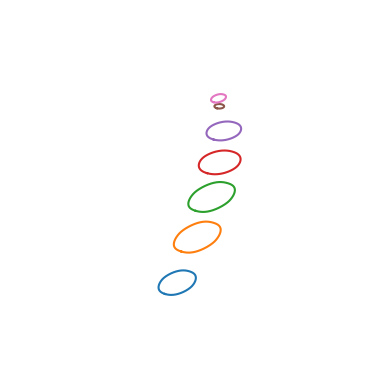

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(r)):
    ax.plot(R[i, :, 0], R[i, :, 1], Z[i]*np.ones(r.shape[1]+1, dtype=np.float32))

plt.axis('equal')
plt.axis('off')
plt.show()

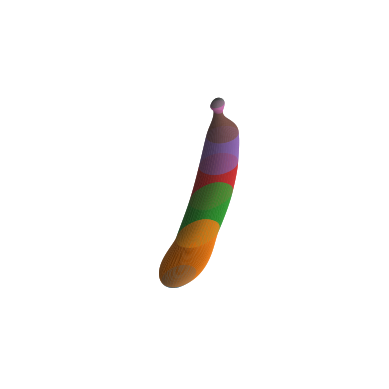

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(FR.shape[0]):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :])

plt.axis('equal')
plt.axis('off')
plt.show()

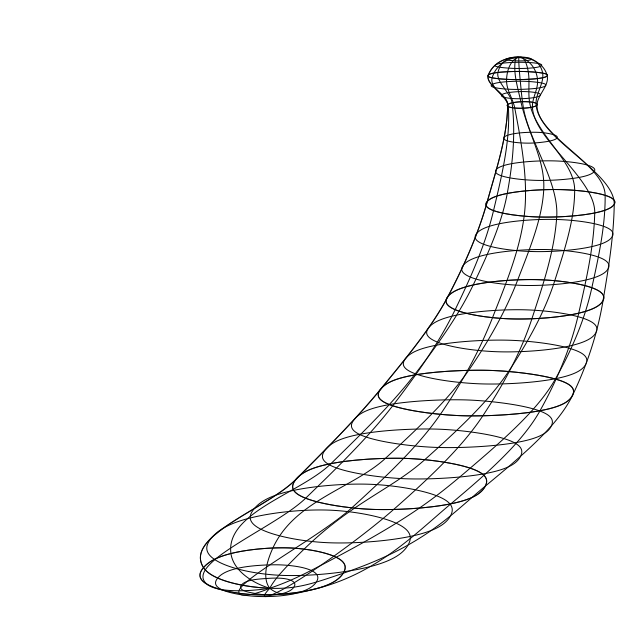

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for i in range(FR.shape[0]):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 3.5)
ax.set_zlim(-1.5, 1.5)
# plt.axis('equal')
ax.view_init(elev=10, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana.png", dpi=300, transparent=True)
plt.show()

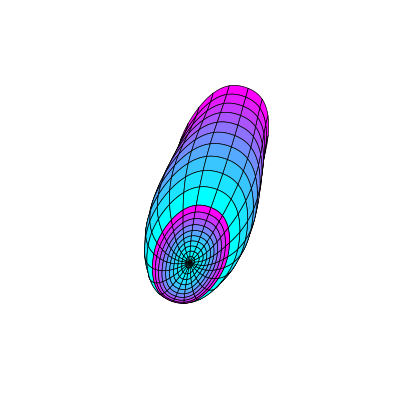

In [10]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,2):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=-70, azim=70) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana_base.png", dpi=300, transparent=True)
plt.show()

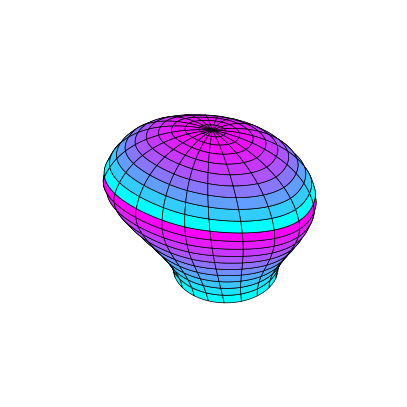

In [11]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(6,8):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=40, azim=20) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("banana_crown.png", dpi=300, transparent=True)
plt.show()

## Apple:

In [12]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'apple'
dt = np.float64

I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)

tot_pts, seg_pts = t_no_pts(I, n1)

N = len(seg_pts)
M = 4
step = tot_pts // M

r = []
for k in range(len(I)):
    r.append(curve_goodman(I[k], seg_pts[k]))

r = np.stack(r)
R = match_parameters(r, N, tot_pts, M)
B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

if ds == 'apple':
  B = Null_Hts[0]
  T = Null_Hts[1]
  bt = ct = 'n'
else:
  B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
  bt = ct = 'y'

t3 = time.perf_counter()
gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
t4 = time.perf_counter()
FR, Fz = surf_pts(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)


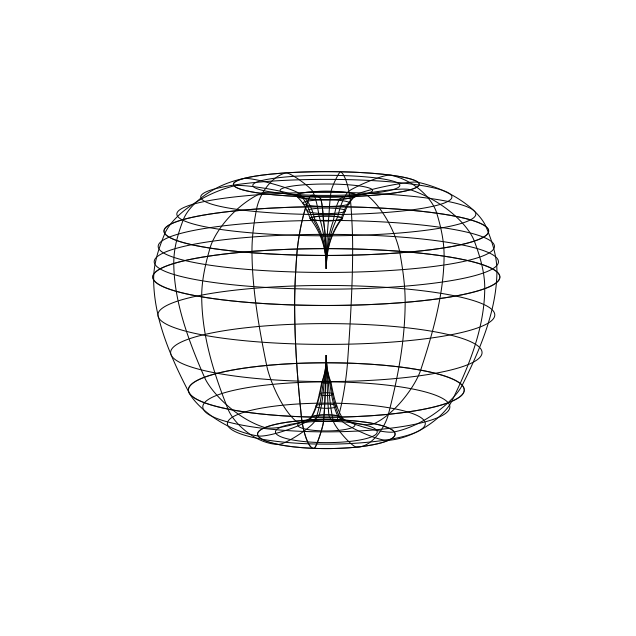

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


for i in range(FR.shape[0]):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')

plt.axis('equal')
ax.view_init(elev=10, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple.png", dpi=300, transparent=True)
plt.show()

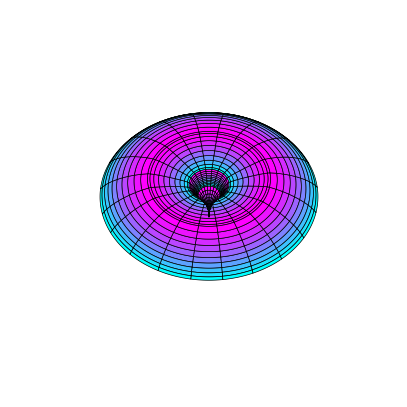

In [14]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(6,10):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')
plt.axis('equal')
ax.view_init(elev=-50, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple_crown.png", dpi=300, transparent=True)
plt.show()

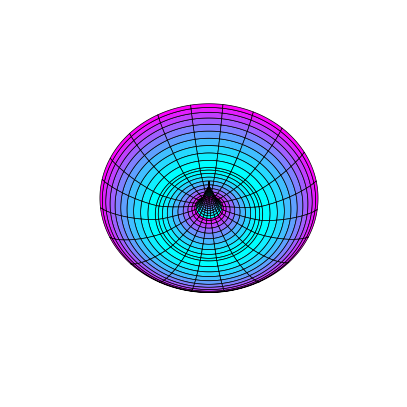

In [15]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,4):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('equal')
ax.view_init(elev=60, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("apple_base.png", dpi=300, transparent=True)
plt.show()

# Vase:

In [18]:
n1 = 500 # The number of points generated horizontally on each countour = 60 * n1
n2 = 2000 # The number of points generated in vertical directions

ds = 'vase'
dt = np.float64

I, Z, Null_Hts = data_3d_shape(ds, dtype=dt)

tot_pts, seg_pts = t_no_pts(I, n1)

N = len(seg_pts)
M = 4
step = tot_pts // M

r = []
for k in range(len(I)):
    r.append(curve_goodman(I[k], seg_pts[k]))

r = np.stack(r)
R = match_parameters(r, N, tot_pts, M)
B_Point, C_Point = base_crown_pt(R, N, tot_pts, M, step)

if ds == 'apple':
  B = Null_Hts[0]
  T = Null_Hts[1]
  bt = ct = 'n'
else:
  B, T = base_crown_ht(R, N, tot_pts, M, step, Z, Null_Hts)
  bt = ct = 'y'

t3 = time.perf_counter()
gR, gz, gRB, gRC, fb, fc = surf_tangent(R, N, tot_pts, Z, Null_Hts, B_Point, C_Point, B, T, bt, ct)
t4 = time.perf_counter()
FR, Fz = surf_pts(R, N, tot_pts, Z, B_Point, C_Point, B, T, gRB, gRC, fb, fc, gR, gz, bt, ct, n2)


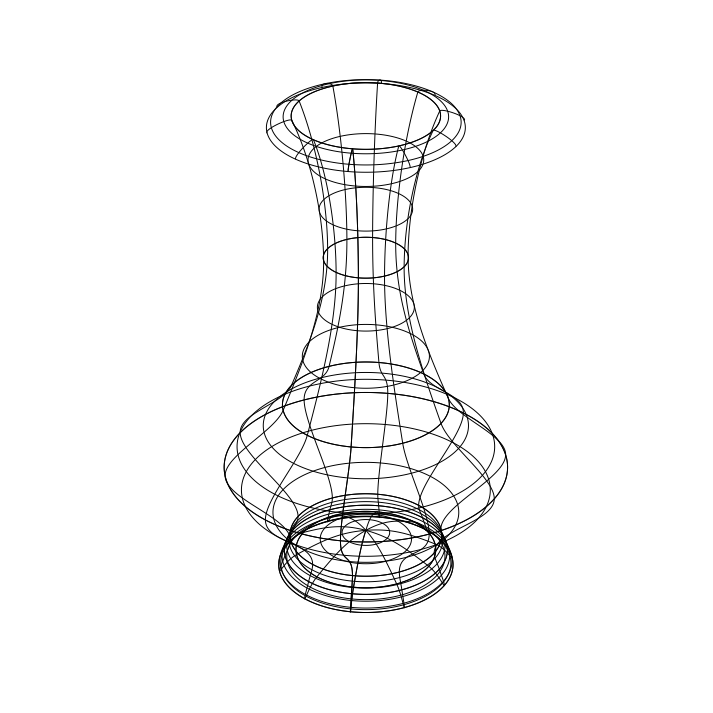

In [19]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')


for i in range(0, FR.shape[0]-1):
    ax.plot_wireframe(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=10, ccount=3, linewidth=0.7, edgecolor='k')

plt.axis('square')
ax.view_init(elev=30, azim=10) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("vase.png", dpi=300, transparent=True)
plt.show()

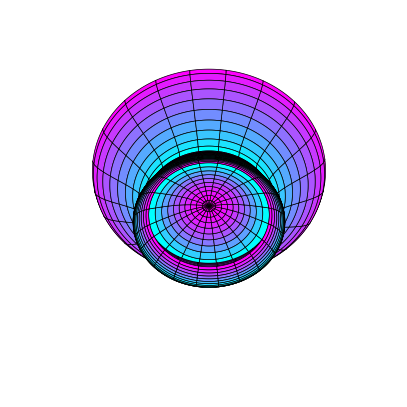

In [20]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,5):
    ax.plot_surface(FR[i, :, :, 0], FR[i, :, :, 1], Fz[i, :, :], rcount=20, ccount=10, linewidth=0.5, edgecolor='k', cmap='cool')

plt.axis('square')
ax.view_init(elev=-60, azim=100) # Set elevation to 30 degrees and azimuth to 45 degrees
plt.axis('off')
# Optional: Save with a different format and parameters
plt.savefig("vase_base.png", dpi=300, transparent=True)
plt.show()